### Import the dataset with labels

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import random
from scipy.io import loadmat

from tsfresh import extract_relevant_features

import os

In [2]:
# files = [f'waveforms/{f}' for f in os.listdir('waveforms') if 'HG8707' in f or 'HJ3311' in f]
# files = [f'waveforms/{f}' for f in os.listdir('waveforms') if 'clean' in f and 'diast' not in f and 'trended' not in f]

class epahClassifier():
    def __init__(self, waveforms=None, labels=None):
        self.waveforms = waveforms
        self.labels = labels
    
    def load_waveforms_from_files(self, files):
        # Load time series into DataFrame
        df_list = []
        for file in files:
            # Load ECG data from the downloaded MATLAB file
            mat = loadmat(file)
            file_id = file.split('.')[0]
            file_id = file_id.split('/')[-1]
            
            # For now, there are two types of files
            # - Files ending in '_000' only contain ONE waveform
            # - Files containing 'clean' may contain MULTIPLE waveforms
            if 'wave' in mat:
                # Note: Each file only contains ONE waveform!
                wave = mat['wave'][0][0][13][3]

                for i, x in enumerate(wave):
                    df_dict = {
                        'id':      file_id,
                        'time':    i,
                        'value':   wave[i],
                    }

                    df_list.append(df_dict)
                    
            elif 'savecleanforms' in mat:
                # Note: Each file may contain multiple waveforms!
                waves = mat['savecleanforms']['wave']
                
                # Create entries for each waveform in the mat file
                for wave_num, wave in enumerate(waves.item()[0]):
                    wave = wave[0]
                    
                    for i, x in enumerate(wave):
                        df_dict = {
                            'id':      f'{file_id}_{wave_num}',
                            'time':    i,
                            'value':   wave[i],
                        }
                        
                        df_list.append(df_dict)

        self.waveforms = pd.DataFrame(df_list)
    
    def load_labels_from_files(self, files):
        # Load labels into Data Series
        labels_dict = {}
        ind = []
        for file in files:
            file_id = file.split('_')[0]
            
            if mat.has_key('wave'):
                # Note: Each file only contains ONE waveform!
                labels_dict[file_id] = int(data[0] % 2)
                ind.append(file_id)
                
            elif mat.has_key('savecleanforms'):
                # Note: Each file may contain multiple waveforms!
                labels_dict[file_id] = int(data[0] % 2)
                ind.append(file_id)

        self.labels = pd.Series(labels_dict, index=ind)

In [17]:
epah = epahClassifier()

files_in_folder = [f'waveforms/{f}' for f in os.listdir('waveforms') if 'clean' in f and 'diast' not in f and 'trended' not in f and 'EL1030' not in f]
# files_in_folder = [f'waveforms/{f}' for f in os.listdir('waveforms') if 'clean' in f and'diast' not in f and 'trended' not in f]

df_labels = pd.read_csv('labels.csv')
df_labels['Filename'] = df_labels['Filename'].str.strip()
df_labels = df_labels.set_index(['Filename'])
df_labels['File_Exists'] = [any(filename.split('_')[0] in f for f in files_in_folder) for filename in df_labels.index]
df_labels['RHC_and_Exists'] = ~df_labels['RHC_or_CPET'] & df_labels['File_Exists']
df_labels['Label'] = df_labels['Source'].map({'control': 0, 'pah': 1, 'epah': 2})

files = [f'waveforms/{f.strip()}cleanforms.mat' for f in df_labels[df_labels['RHC_and_Exists']].index]

epah.load_waveforms_from_files(files)

print(f'Data Size: {len(files)}')

print(f'# Waveforms: {len(epah.waveforms.id.unique())}')

Data Size: 25
# Waveforms: 156


In [18]:
id_list = list(epah.waveforms['id'])

labels_dict = {}
for file_id in id_list:
    labels_dict[file_id] = df_labels.loc[file_id.split('clean')[0]]['Label']

epah.labels = pd.Series(labels_dict, index=list(labels_dict.keys()))

print(epah.labels.value_counts())

2    65
1    61
0    30
dtype: int64


In [49]:
waveforms = epah.waveforms['id'].unique()
for wave_id in waveforms:
    id_mask = epah.waveforms['id'].str.contains(wave_id, regex=False)
    epah.waveforms.loc[id_mask, 'value_norm'] = (epah.waveforms[id_mask]['value'] - epah.waveforms[id_mask]['value'].mean()) / epah.waveforms[id_mask]['value'].std()
#     epah.waveforms.loc[id_mask, 'value_norm'] = (epah.waveforms[id_mask]['value'] - epah.waveforms[id_mask]['value'].min()) / (epah.waveforms[id_mask]['value'].max() - epah.waveforms[id_mask]['value'].min())

epah.waveforms

,id,time,value,value_norm
0,HJ6108_WAV_004cleanforms_0,0,-5.085034,-0.711384
1,HJ6108_WAV_004cleanforms_0,1,-5.066263,-0.709025
2,HJ6108_WAV_004cleanforms_0,2,-5.047492,-0.706667
3,HJ6108_WAV_004cleanforms_0,3,-5.048721,-0.706821
4,HJ6108_WAV_004cleanforms_0,4,-5.029950,-0.704462
...,...,...,...,...
33934,HH3542_WAV_004cleanforms_6,251,-8.678522,-0.894754
33935,HH3542_WAV_004cleanforms_6,252,-8.657779,-0.892550
33936,HH3542_WAV_004cleanforms_6,253,-8.577036,-0.883971
33937,HH3542_WAV_004cleanforms_6,254,-8.536293,-0.879642


### Create Pipeline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh.utilities.dataframe_functions import impute

In [71]:
# Classes:
# 0: Control
# 1: PAH
# 2: EPAH

# Remove Class
# -1 -->  keep all 3 classes
# 0  -->  PAH vs EPAH
# 1  -->  Control vs EPAH
# 2  -->  Control vs PAH
class_remove = 2

y = epah.labels[epah.labels != class_remove]

X = pd.DataFrame(index=y.index)

# Split data into train and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# Ensure even split between labels
# FOR NOW, pick 2 patients randomly from each class
pt_list = list(set(ind.split('_')[0] for ind in y.index))

pt_labels = []
for pt in pt_list:
    label = y[[pt in ind for ind in y.index]][0]
    weight = sum([pt in ind for ind in y.index])
    
    pt_labels.append({
        'pt':     pt,
        'label':  label,
        'weight': weight,
    })

pt_df = pd.DataFrame(pt_labels)

if class_remove == 0:
    pt_test = pd.concat([pt_df[pt_df['label'] == 1].sample(n=3),
                         pt_df[pt_df['label'] == 2].sample(n=3)])
elif class_remove == 1:
    pt_test = pd.concat([pt_df[pt_df['label'] == 0].sample(n=2),
                         pt_df[pt_df['label'] == 2].sample(n=3)])
elif class_remove == 2:
    pt_test = pd.concat([pt_df[pt_df['label'] == 0].sample(n=2),
                         pt_df[pt_df['label'] == 1].sample(n=3),])
else:
    pt_test = pd.concat([pt_df[pt_df['label'] == 0].sample(n=2),
                         pt_df[pt_df['label'] == 1].sample(n=3),
                         pt_df[pt_df['label'] == 2].sample(n=3)])

display(pt_test)

y_train = y[[all(pt not in ind for pt in pt_test['pt']) for ind in y.index]]
X_train = X[[all(pt not in ind for pt in pt_test['pt']) for ind in X.index]]
y_test = y[[any(pt in ind for pt in pt_test['pt']) for ind in y.index]]
X_test = X[[any(pt in ind for pt in pt_test['pt']) for ind in X.index]]

print(f'Training Split: {len(y_train)}')
print(f'Testing  Split: {len(y_test)}')

,pt,label,weight
6,HJ6108,0,6
12,HJ5111,0,6
4,HJ7535,1,6
9,HJ6202,1,7
8,HH3071,1,6


Training Split: 60
Testing  Split: 31


In [72]:
df_waveforms = epah.waveforms.copy()
df_waveforms = df_waveforms.drop(columns=['value'])

ppl = Pipeline([
        ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='time')),
        ('classifier', RandomForestClassifier())
      ])

ppl.set_params(augmenter__timeseries_container=df_waveforms[df_waveforms['id'].isin(y.index)])

ppl.fit(X_train, y_train)

y_pred = ppl.predict(X_test)

print(classification_report(y_test, y_pred))

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]
C:\Users\andre\miniconda3\envs\epahClassification\lib\site-packages\tsfresh\utilities\dataframe_functions.py:171: RuntimeWarning: The columns ['value_norm__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.93it/s]

              precision    recall  f1-score   support

           0       1.00      0.42      0.59        12
           1       0.73      1.00      0.84        19

    accuracy                           0.77        31
   macro avg       0.87      0.71      0.72        31
weighted avg       0.83      0.77      0.75        31



Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.71it/s]


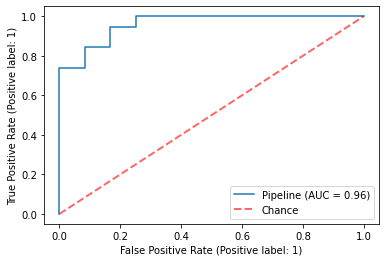

In [73]:
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots()
plot_roc_curve(ppl, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.6)
ax.legend()

In [ ]:
ppl.named_steps["augmenter"].feature_selector.relevant_features

In [46]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table

In [103]:
df_waveforms = epah.waveforms.copy()
df_waveforms = df_waveforms.drop(columns=['value'])

# Remove Class
# -1 -->  keep all 3 classes
# 0  -->  PAH vs EPAH
# 1  -->  Control vs EPAH
# 2  -->  Control vs PAH
class_remove = 2

y = epah.labels[epah.labels != class_remove]

extracted_features = extract_features(df_waveforms[df_waveforms['id'].isin(y.index)], column_id='id', column_sort='time', column_value='value_norm')
impute(extracted_features)
df_relevance_table = calculate_relevance_table(extracted_features, y)
df_relevance_table

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.36it/s]
C:\Users\andre\miniconda3\envs\epahClassification\lib\site-packages\tsfresh\utilities\dataframe_functions.py:171: RuntimeWarning: The columns ['value_norm__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


,feature,type,p_value,relevant
feature,,,,
"value_norm__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",value_norm__cwt_coefficients__coeff_0__w_20__w...,real,3.723055e-11,True
"value_norm__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)",value_norm__cwt_coefficients__coeff_1__w_20__w...,real,5.864146e-11,True
"value_norm__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","value_norm__agg_linear_trend__attr_""slope""__ch...",real,6.564896e-11,True
"value_norm__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)",value_norm__cwt_coefficients__coeff_2__w_20__w...,real,1.087255e-10,True
"value_norm__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","value_norm__agg_linear_trend__attr_""rvalue""__c...",real,1.149542e-10,True
...,...,...,...,...
value_norm__ratio_beyond_r_sigma__r_5,value_norm__ratio_beyond_r_sigma__r_5,constant,NaN,False
value_norm__ratio_beyond_r_sigma__r_6,value_norm__ratio_beyond_r_sigma__r_6,constant,NaN,False
value_norm__ratio_beyond_r_sigma__r_7,value_norm__ratio_beyond_r_sigma__r_7,constant,NaN,False


In [104]:
df_relevance_table.to_csv('relevance_table.csv')

### Create Images of Each Waveform

In [101]:
waves = epah.waveforms['id'].unique()

for wave in waves:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    label = df_labels.loc[wave.split('clean')[0]]['Source']
    values = epah.waveforms[epah.waveforms['id'].str.contains(wave, regex=False)]['value']
    
    ax.plot(np.arange(0, len(values)), values)
    ax.set_title(f'{wave}  /  Label: {label}  /  Mean: {values.mean():0.3f} ± {values.std():0.3f}', fontsize=14)
    
#     break
    
    fig.savefig(f'waveforms_images/{wave}_image.jpg')
    plt.close()